# Figure 2: belief dynamics

In [7]:
# imports
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from pathlib import Path
import numpy as np
import re
import json

In [8]:
# parameters
BASE_DIR = Path.cwd().parent
LOGITS_DIR = BASE_DIR / "data" / "logits"
SEQUENCES_DIR = BASE_DIR / "data" / "sequences"
ACTIVS_DIR = BASE_DIR / "data" / "activations"
dataroot = "gaussian_m300_s100_l1000_n10+gaussian_m700_s100_l1000_n10"
sequence_idx = 9
layer_for_acts_plot = 14
start_number_idx = 500

temperature = 1.0
eps = 1e-12
cmap = "inferno"
cm = 1 / 2.54

save_figures = False

In [9]:
# load data
logit_datapath = LOGITS_DIR / dataroot
files = sorted(logit_datapath.glob("logits_batch*.pt"))
if not files:
    raise FileNotFoundError(f"No logits files found in {logit_datapath}")

logits_list = []
labels = None
for fpath in files:
    payload = torch.load(fpath, map_location="cpu")
    logits_list.append(payload["logits"])
    token_labels = payload.get("token_strings") or payload.get("token_labels")
    if labels is None:
        labels = token_labels
    elif token_labels != labels:
        raise ValueError(f"Token label order mismatch in {fpath}")

logits = torch.cat(logits_list, dim=0)
probs = torch.softmax(logits / temperature, dim=-1)

# sort labels: numeric first (ascending), then other, then punctuation in this order
punctuation_order = [",", "-", ".", ";", "_", " "]
numeric_pairs, punct_indices, other_indices = [], [], []
for idx, label in enumerate(labels):
    try:
        numeric_pairs.append((int(label), idx))
    except ValueError:
        (punct_indices if label in punctuation_order else other_indices).append(idx)

numeric_pairs.sort(key=lambda pair: pair[0])
punct_indices_sorted = [idx for label in punctuation_order for idx in punct_indices if labels[idx] == label]
sorted_indices = [idx for _, idx in numeric_pairs] + other_indices + punct_indices_sorted
sorted_labels = [labels[idx] for idx in sorted_indices]

# pull sequence-specific probs
sorted_probs = probs[:, :, sorted_indices]
num2com_probs = sorted_probs[sequence_idx, 1::2].numpy()
com2num_probs = sorted_probs[sequence_idx, 2::2].numpy()

def load_sequence_text(dataset_name: str, index: int) -> str:
    jsonl_path = SEQUENCES_DIR / f"{dataset_name}.jsonl"
    with jsonl_path.open("r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
            record = json.loads(line)
            if i == index:
                return record["sequence_content"]
    raise ValueError(f"Sequence index {index} not found in {jsonl_path}")

def sequence_text_for_index(index: int) -> str:
    dataset_names = [name.strip() for name in dataroot.split("+") if name.strip()]
    return "".join(load_sequence_text(name, index) for name in dataset_names)

# numeric tokens per sequence
n_seqs = probs.shape[0]
numbers = []
for i in range(n_seqs):
    seq_text = sequence_text_for_index(i)
    nums = [int(tok) for tok in seq_text.split(",") if re.fullmatch(r"-?\d+", tok)]
    numbers.append(nums)


In [10]:
# mean and std from logits as a function of position

# calculate moments
# mask + values for numeric subset (e.g., "23" -> 23, "-7" -> -7)
numeric_mask = [re.fullmatch(r"-?\d+", str(lbl)) is not None for lbl in sorted_labels]
numeric_values = np.array(
    [int(lbl) for lbl, keep in zip(sorted_labels, numeric_mask) if keep],
    dtype=np.float64,
)

numeric_probs = com2num_probs[:, numeric_mask]           # [positions, num_numeric]
numeric_mass = numeric_probs.sum(axis=1, keepdims=True)  # probability on numeric tokens
safe_mass = np.clip(numeric_mass, 1e-12, None)           # avoid divide-by-zero

# expected value and std for each com→num position
means = (numeric_probs @ numeric_values) / safe_mass[:, 0]
var = ((numeric_probs * (numeric_values - means[:, None]) ** 2).sum(axis=1)) / safe_mass[:, 0]
stds = np.sqrt(var)

# central moments up to 4th
central = numeric_values - means[:, None]
m2 = (numeric_probs * central**2).sum(axis=1) / safe_mass[:, 0]
m4 = (numeric_probs * central**4).sum(axis=1) / safe_mass[:, 0]

# raw kurtosis (Fisher’s definition minus 3 if you want excess)
kurtosis = m4 / np.clip(m2, 1e-12, None)**2
excess_kurtosis = kurtosis - 3.0


print("means (first 5):", means[:5])
print("stds  (first 5):", stds[:5])
print("kurtosis (first 5):", kurtosis[:5])

means (first 5): [495.72754382 509.44490182 536.70128218 543.23372233 545.29728493]
stds  (first 5): [277.04434588 264.17595488 263.76050176 261.80242046 263.34840303]
kurtosis (first 5): [1.90124196 1.82595947 1.87035688 1.84534982 1.82074737]


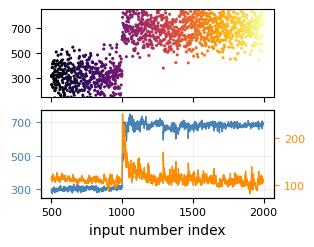

In [11]:
# plot input numbers and output moments

plt.rcParams.update({"font.size": 10})
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1, figsize=(7.7 * cm, 6 * cm), constrained_layout=True
)

# Top: numeric tokens from start onward
series = numbers[sequence_idx][start_number_idx:]
x_series = np.arange(start_number_idx, start_number_idx + len(series))
ax_top.scatter(x_series, series, c=x_series, cmap=cmap, s=5, linewidths=0)
ax_top.set_yticks([300, 500, 700])
ax_top.set_ylim([150, 850])
ax_top.tick_params(axis="x", which="both", labelbottom=False, labelsize=8)
ax_top.tick_params(axis="y", labelsize=8)

# Bottom: mean & std vs position (aligned to the kept positions)
pos_idx = np.arange(start_number_idx, start_number_idx + len(means[start_number_idx:]))
ax_std = ax_bottom.twinx()
ax_bottom.plot(pos_idx, means[start_number_idx:], color="steelblue", marker="o", ms=0, lw=1, label="mean")
ax_std.plot(pos_idx, stds[start_number_idx:], color="darkorange", marker="s", ms=0, lw=1, label="std")

ax_bottom.set_xlabel("input number index")
ax_bottom.set_yticks([300, 500, 700])
ax_bottom.tick_params(axis="y", colors="steelblue", labelsize=8)
ax_std.tick_params(axis="y", colors="darkorange", labelsize=8)
ax_bottom.tick_params(axis="x", labelsize=8)
ax_bottom.grid(True, alpha=0.3, lw=0.5)

if save_figures:
    fig.savefig("pdf/figure02a.pdf", bbox_inches="tight", dpi=300)
    
plt.show()


(4001, 2048)
4001
(1500, 2048)


/tmp/ipykernel_2007762/2906437896.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap)


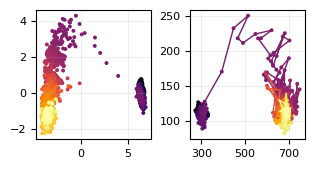

In [12]:
# plot activations and distribution trajectories

plt.rcParams.update({"font.size": 8})

acts_path = ACTIVS_DIR / dataroot
pattern = f"model_layers_{layer_for_acts_plot}_batch*.pt"
act_files = sorted(acts_path.glob(pattern))
if not act_files:
    raise FileNotFoundError(f"No activation files found in {acts_path / pattern}")

acts_list = []
lengths_list = []
for fpath in act_files:
    payload = torch.load(fpath, map_location="cpu")
    acts_list.append(payload["activations"])
    lengths = payload.get("lengths")
    if lengths is not None:
        lengths_list.append(lengths)

activations = torch.cat(acts_list, dim=0)
lengths = torch.cat(lengths_list, dim=0) if lengths_list else None
seq_len = int(lengths[sequence_idx].item()) if lengths is not None else activations.shape[1]
seq_acts = activations[sequence_idx, :seq_len].numpy()
print(seq_acts.shape)
print(seq_len)
# positions aligned with mean/std (comma→number indices)
token_positions = np.arange(seq_len)[2::2][: len(means)]
sel_acts = seq_acts[2::2]
sel_acts = sel_acts[start_number_idx:]
print(sel_acts.shape)

# PCA (center + SVD)
X = torch.tensor(sel_acts)
Xc = X - X.mean(dim=0, keepdim=True)
_, _, Vh = torch.linalg.svd(Xc, full_matrices=False)
pca2 = Xc @ Vh[:2].T
pc1, pc2 = pca2[:, 0].numpy(), pca2[:, 1].numpy()

# --- figure with PCA (left) and mean/std trajectory (right) ---
fig, (ax_left, ax_right) = plt.subplots(
    1, 2, figsize=(7.7 * cm, 4 * cm), constrained_layout=True
)

# Left: PCA scatter (no colorbar)
idx = np.arange(len(pc1))
ax_left.scatter(pc1, pc2, c=idx, cmap=cmap, s=8, edgecolors="none")
# ax_left.set_xlabel("PC1")
# ax_left.set_ylabel("PC2")
ax_left.grid(True, alpha=0.3, lw=0.5)
ax_left.tick_params(labelsize=8)

# Right: trajectory in std–mean plane (your spec)
means_truncated = means[start_number_idx:]
stds_truncated = stds[start_number_idx:]
idx = np.arange(len(means_truncated))
cmap = plt.cm.get_cmap(cmap)
colors = cmap(np.linspace(0, 1, len(idx)))

for i in range(len(idx) - 1):
    ax_right.plot(
        [means_truncated[i], means_truncated[i + 1]],
        [stds_truncated[i], stds_truncated[i + 1]],
        color=colors[i],
        lw=1.0,
    )
ax_right.scatter(means_truncated, stds_truncated, c=idx, cmap=cmap, s=8, edgecolors="none")
ax_right.grid(True, alpha=0.3, lw=0.5)
ax_right.set_xticks([300, 500, 700])
ax_right.set_yticks([100, 150, 200, 250])
ax_right.tick_params(labelsize=8)
ax_left.tick_params(labelsize=8)

if save_figures:
    fig.savefig("pdf/figure02b.pdf", bbox_inches="tight", dpi=300)
    
plt.show()
